In [1]:
import scanpy as sc
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
from model import ConditionalZINBVAE
from dataset import base_genes
from training import train
from utils import sample_zinb, set_seed, plot_umap_pca

ImportError: cannot import name 'ConditionalZINBVAE' from 'model' (/mnt/data2/home/leonardo/git/excercise_ai4bio/model.py)

In [ ]:
n_cells=10000
n_genes=20
target_zero_prob=.8

In [ ]:
x, mu_values, theta_values, pi_values = base_genes(n_cells=n_cells, 
                                                    n_genes=n_genes, 
                                                    target_zero_prob=target_zero_prob, 
                                                    mu_bot=1.0, 
                                                    mu_top=10, 
                                                    theta_bot=0.5, 
                                                    theta_top=2.0,
                                                    seed=42)

Actual overall zero proportion: 0.7997


In [ ]:
tile_up = lambda x : np.vstack((x, x))

mu_values_combined, theta_values_combined, pi_values_combined = [tile_up(mat) for mat in [mu_values, theta_values, pi_values]]

In [ ]:
x_perturbed = x.copy()
x_perturbed +=10

# Stack original and perturbed data
x_combined = np.vstack((x, x_perturbed))

# Create AnnData object
adata = sc.AnnData(x_combined)

# Create state labels: first n_cells are control, next n_cells are perturbed
states = ["control"] * n_cells + ["perturbed"] * n_cells
adata.obs["state"] = pd.Categorical(states)

/mnt/data2/home/leonardo/miniconda3/envs/scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


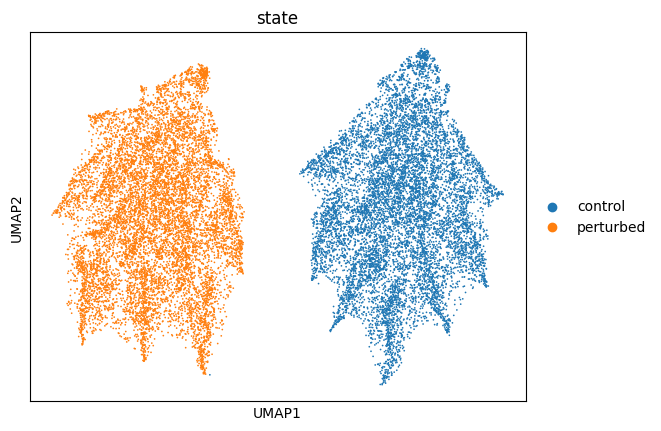

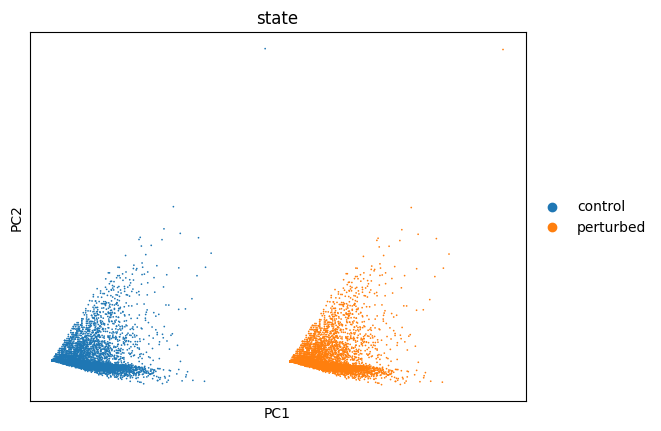

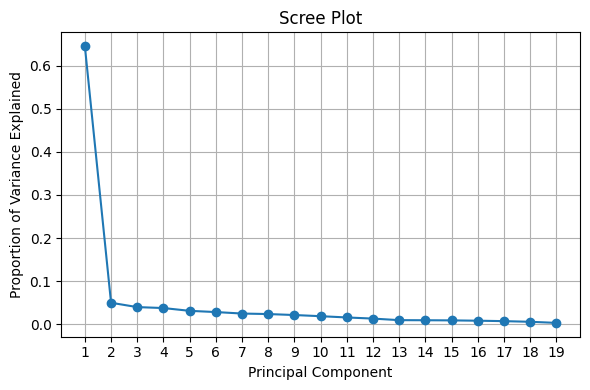

In [ ]:
plot_umap_pca(adata, color="state", random_state=0)

In [ ]:
# Convert categorical state to one-hot encoding.
# For two states, this will create a (2*n_cells, 2) matrix.
state_onehot = pd.get_dummies(adata.obs["state"]).values

# Convert one-hot labels to a PyTorch tensor.
s_combined = torch.tensor(state_onehot, dtype=torch.float32)

# ----------------------------
# Training Code for the Conditional VAE
# ----------------------------
n_epochs = 1000
set_seed(10)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# s_dim is the number of states (e.g. 2 for control and perturbed)
s_dim = s_combined.shape[1]

# Instantiate the model with the new Conditional architecture.
# x_combined.shape[1] is the input dimensionality (number of genes)
vae = ConditionalZINBVAE(input_dim=x_combined.shape[1], s_dim=s_dim, hidden_dim=40, latent_dim=10).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Convert x_combined to a PyTorch tensor
x_tensor = torch.tensor(x_combined, dtype=torch.float32).to(device)

# Call your training function. Note that the training function must be updated
# to accept both x and s inputs. Here we assume it follows the signature:
# train(model, optimizer, x, s, n_epochs, n_cells, mu_values, theta_values, pi_values, seed, device)
mean, disp, pi, mu, logvar, z = train(vae, optimizer, x_tensor, s_combined, n_epochs, n_cells, 
                                      mu_values_combined, theta_values_combined, pi_values_combined,
                                      seed=11, device=device)

# Helper to convert outputs from PyTorch tensors to NumPy arrays
to_numpy = lambda x: x.detach().cpu().numpy() if hasattr(x, 'detach') else np.array(x)
mean, disp, pi, mu, logvar, z = list(map(to_numpy, [mean, disp, pi, mu, logvar, z]))

/mnt/data2/home/leonardo/git/excercise_ai4bio/training.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(device)


Epoch 0, Loss: 6446712.5000, Mean MSE: 8647069.0000, Theta MSE: 12269534.0000, Pi MSE: 0.0695
Epoch 1, Loss: 2198102.2500, Mean MSE: 4195488.5000, Theta MSE: 3491619.7500, Pi MSE: 0.0695
Epoch 2, Loss: 872352.3750, Mean MSE: 128184.3281, Theta MSE: 90932.5156, Pi MSE: 0.0697
Epoch 3, Loss: 399645.8125, Mean MSE: 899482.3125, Theta MSE: 636087.8750, Pi MSE: 0.0700
Epoch 4, Loss: 206039.0000, Mean MSE: 882116.8125, Theta MSE: 520367.5938, Pi MSE: 0.0707
Epoch 5, Loss: 116814.1875, Mean MSE: 1851282.8750, Theta MSE: 2066035.5000, Pi MSE: 0.0718
Epoch 6, Loss: 72664.9688, Mean MSE: 1856841.6250, Theta MSE: 670033.1875, Pi MSE: 0.0729
Epoch 7, Loss: 48224.3281, Mean MSE: 74579.8281, Theta MSE: 52212.1094, Pi MSE: 0.0741
Epoch 8, Loss: 33679.6211, Mean MSE: 116522.7109, Theta MSE: 111049.7344, Pi MSE: 0.0755
Epoch 9, Loss: 24538.9023, Mean MSE: 386911.5625, Theta MSE: 83779.3438, Pi MSE: 0.0771
Epoch 10, Loss: 18531.0508, Mean MSE: 107380.0234, Theta MSE: 47097.6758, Pi MSE: 0.0786
Epoch 11,

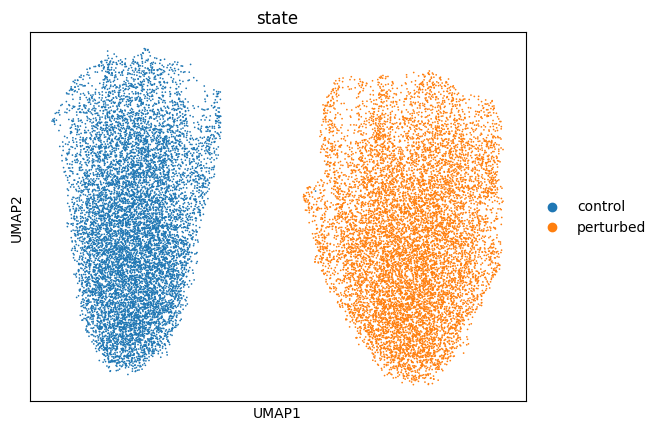

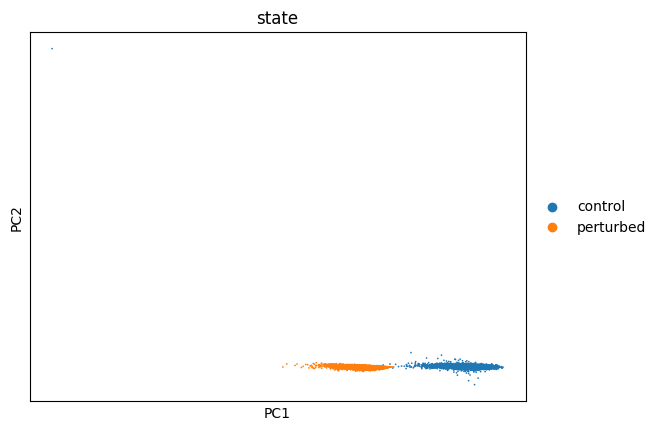

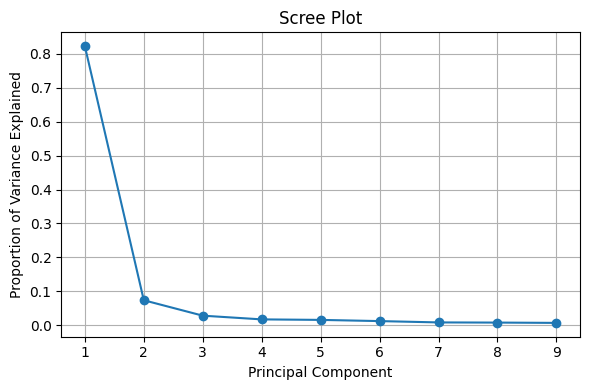

In [ ]:
adata_z = sc.AnnData(X=z)
adata_z.obs["state"] = adata.obs["state"].copy()

plot_umap_pca(adata_z, color="state", random_state=0)